In [1]:
import warnings
warnings.filterwarnings("ignore")

import bz2 
import pickle
import _pickle as cPickle
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
import itertools
from itertools import combinations
import logging, sys
import gensim
import numpy as np
import matplotlib.pyplot as plt
import os

In [97]:
# load in cPickle file for Geophysics (OpenAlex ID C8058405)
discipline = 'C8058405'

# load in cPickle file for Statistics (OpenAlex ID C105795698)
discipline = 'C105795698'

# load in cPickle file for Oceanography (OpenAlex ID C111368507)
discipline = 'C111368507'

# load in cPickle file for Biophysics (OpenAlex ID C12554922)
discipline = 'C12554922'

# load in cPickle file for Meteorology (OpenAlex ID C153294291)
discipline = 'C153294291'

# load in cPickle file for Atomic physics (OpenAlex ID C184779094)
discipline = 'C184779094'

# load in cPickle file for Thermodynamics (OpenAlex ID C97355855)
discipline = 'C97355855'

data = 'Data\OUTPUT_Python_OpenAlex_Citation_and_Abstract_Data_' + discipline + '.pbz2'

f = bz2.BZ2File(data, 'rb')
paper_id_year_df = cPickle.load(f)
corpus_dict = cPickle.load(f)
citation_df = cPickle.load(f)

In [98]:
def reformat(dictionary):
    '''
    Takes the Object 2 dictionary and casts it into a dataframe
    '''
    # remove OpenAlex ID
    field_dictionary = dictionary[1]
    # reformat to list
    field_list = list(map(list, field_dictionary.items()))
    # cast into dataframe and rename columns
    field_df = pd.DataFrame(field_list)
    field_df = field_df.rename(columns = {0: 'work_id', 1: 'terms'})
    
    return field_df

def add_year(field_df, paper_id_year_df):
    '''
    Takes the Object 2 dataframe and merges it with corresponding publication years from Object 1
    '''
    # merge the two dataframes
    merged = pd.merge(field_df, paper_id_year_df, on ='work_id', how ='inner')
    # reorder columns
    columns = merged.columns.tolist()
    columns = columns[-1:] + columns[-2:-1] + columns[:-2]
    reordered = merged[columns]
    
    return reordered

def lowercase(dataframe, column):
    '''
    takes a dataframe and lowercases everything within a specified column (column contents must be in a list of strings)
    '''
    dataframe[column] = dataframe[column].apply(lambda lst: [word.lower() for word in lst])
    return dataframe

regex = r'[^a-z\s]'

def tokenize(text):
    '''
    Cleans, tokenizes + stems Pandas series of strings    
    Returns pandas series of lists of tokens (casted into dataframe)
    '''
    # Clean text with regex
    clean = text.str.lower().str.replace(regex, '', regex=True)

    # Anonymous tokenizer + stemmer functions
    stop = nltk.corpus.stopwords.words('english')
    tokenize = lambda text: [i for i in nltk.word_tokenize(text) if i not in stop]
    stemmer = lambda tokens: [SnowballStemmer('english').stem(token) for token in tokens]

    # Tokenize and stem clean text
    tokens = clean.apply(tokenize)
    stemmed_tokens = tokens.apply(stemmer)
    
    # return series of lists of tokens as dataframe
    return stemmed_tokens.to_frame()

def wordcounter(wordlist, n):
    '''
    Counts terms/words within a list of strings, returns top n terms/words over time
    Idea: Use output as illustrative example of how field progresses (validate with field-specific paper on paradigm shift)
    '''
    counts = {}
    for word in wordlist:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    
    # convert dictionary to list of tuples
    lst_counts = [(key, value) for key, value in counts.items()]
    #sort in descending order
    lst_counts.sort(key = lambda x: x[1], reverse=True)
    
    word_counts_df = {'word' : [], 'count' : []}

    for item in lst_counts:
        word_counts_df['word'].append(item[0])
        word_counts_df['count'].append(item[1])
        
    # return either list or dataframe
    # list: pd.DataFrame(word_counts_df)[:n]
    # dataframe: pd.DataFrame(word_counts_df)[:n]

    return pd.DataFrame(word_counts_df)[:n]

In [99]:
corpus = lowercase(add_year(reformat(next(iter(corpus_dict.items()))), paper_id_year_df), 'terms')
corpus = corpus[['publication_year', 'terms']].set_index('publication_year').sort_values(by=['publication_year'])

# remove rows with empty lists
corpus = corpus[corpus['terms'].map(lambda d: len(d)) > 0]

# reformat row as strings
corpus = corpus.astype({'terms':'string'})

In [100]:
stemmed_tokens = tokenize(corpus['terms'])
stemmed_tokens.reset_index(inplace=True)

# convert publication year to int and remove observations before 2000 and after 2020
stemmed_tokens['publication_year'] = pd.to_numeric(stemmed_tokens['publication_year'])
stemmed_tokens = stemmed_tokens[(stemmed_tokens['publication_year'] >= 2000) & (stemmed_tokens['publication_year'] <= 2020)]

# aggregate documents per year and concatenate the list(s) of words
aggregated = stemmed_tokens.groupby('publication_year', as_index=False)['terms'].agg(lambda x: list(x))

# get number of documents per year
aggregated['documents'] = [len(i) for i in aggregated['terms']]

# convert publication_year from string to integer
aggregated['publication_year'] = pd.to_numeric(aggregated['publication_year'])

print('Full corpus for input data, aggregated by year and with each document as list within list')
display(aggregated.tail())

print('\nFull corpus for input data, preserving individual documents as rows')
stemmed_tokens['publication_year'] = pd.to_numeric(stemmed_tokens['publication_year'])
stemmed_tokens.tail()

Full corpus for input data, aggregated by year and with each document as list within list


,publication_year,terms,documents
16,2016,"[[slag, viscos, molten, slag, viscos, fit, mol...",1411
17,2017,"[[model, various, solut, model, various, compl...",1453
18,2018,"[[tensil, stress, behaviour, snagcu, logarithm...",1804
19,2019,"[[turbul, kinet, kinet, energi, boundari, laye...",2770
20,2020,"[[heat, transfer, conjug, heat, hydrogen, addi...",7817



Full corpus for input data, preserving individual documents as rows


,publication_year,terms
27946,2020,"[heat, transfer, heat, capac, heat, exchang, p..."
27947,2020,"[model, variabl, variabl, densiti, model, vari..."
27948,2020,"[pressur, phase, anvil, cell, temperatur, mean..."
27949,2020,"[nanoparticl, shape, entropi, generat, various..."
27950,2020,"[condens, droplet, experiment, system, surfac,..."


### CUSTOM W2V MODEL (FIXED TERMS, VARIABLE MODEL)

In [101]:
# aggregated dataframe contains list of lists for each year, with each sublist pertaining to a document in tat year
# i.e., for 19XX: [[term1_d1, term2_d1, term3_d1], [term1_d2, term2_d2, term3_d2]]

# combine terms from aggregated df into single master list, to be used as word2vec input
aggregated_2000_2020 = aggregated['terms'].sum()

# bucket terms based on time periods (10Y periods, starting at 1971)
bucket_2000_2010 = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
bucket_2011_2020 = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

# combine terms across years into single list)
aggregated_2000_2010 = aggregated.loc[aggregated['publication_year'].isin(bucket_2000_2010)]['terms'].sum()
aggregated_2011_2020 = aggregated.loc[aggregated['publication_year'].isin(bucket_2011_2020)]['terms'].sum()

In [102]:
# give all sentences to trainer; then run skipgram model with 100 dimensions and negative sampling
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

fieldW2V_2000_2010 = gensim.models.word2vec.Word2Vec(aggregated_2000_2010, vector_size = 100, workers = 3, sg = 1,
                                                     hs = 0, negative = 5)

fieldW2V_2011_2020 = gensim.models.word2vec.Word2Vec(aggregated_2011_2020, vector_size = 100, workers = 3, sg = 1,
                                                     hs = 0, negative = 5)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 4063 word types from a corpus of 100783 raw words and 4560 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1906 unique words (46.911149396997295%% of original 4063, drops 2157)', 'datetime': '2023-03-08T00:17:58.249203', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 96427 word corpus (95.67784249327764%% of original 100783, drops 4356)', 'datetime': '2023-03-08T00:17:58.253192', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 2 : training on 454732 raw words (378599 effective words) took 1.2s, 328404 effective words/s
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 43.83% examples, 165711 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 90.03% examples, 165551 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 3 : training on 454732 raw words (378370 effective words) took 2.2s, 168292 effective words/s
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 81.21% examples, 299847 words/s, in_qsize 5

In [103]:
# set number of words
n = 50

# convert to a single list of terms and get n most frequent terms for Sociology (1962-2012)
words_2000_2020 = stemmed_tokens['terms'].explode().to_list()

# get distance of fixed set of high-frequency words
hf_words = wordcounter(words_2000_2020, n)['word'].tolist()

# get all possible word tuples
word_pair_list = list(itertools.combinations(hf_words, 2))

models = [fieldW2V_2000_2010, fieldW2V_2011_2020]

columns = ['fieldW2V_2000_2010', 'fieldW2V_2011_2020']

# initialize dataframe with word pairs
df = pd.DataFrame({'word pair': word_pair_list})

# loop through models and get distance of all tuples for each model
for model, column in zip(models, columns):
    similarity_list = []
    
    for word_pair in word_pair_list:
        similarity = model.wv.similarity(word_pair[0], word_pair[1])
        similarity_list.append(similarity)
        
    df[column] = similarity_list
    
# calculate min, mean, median, and max for all columns
summary_statistics_2000_2010 =  df.agg({'fieldW2V_2000_2010': [min, 'mean', 'median', max]})
summary_statistics_2011_2020 =  df.agg({'fieldW2V_2011_2020': [min, 'mean', 'median', max]})

# merge summary statistic dataframes and add merged dataframe back to the main one
summary_statistics = pd.concat([summary_statistics_2000_2010, summary_statistics_2011_2020], axis=1)

df = pd.concat([df, summary_statistics], axis=0)

#df['fieldW2V_2011_2020']['min'] = 0

df

,word pair,fieldW2V_2000_2010,fieldW2V_2011_2020
0,"(heat, transfer)",0.758758,0.730413
1,"(heat, phase)",0.149237,0.250565
2,"(heat, temperatur)",0.374865,0.475137
3,"(heat, energi)",0.283433,0.418099
4,"(heat, model)",0.297589,0.260087
...,...,...,...
1224,"(rang, depend)",0.413958,0.405513
min,NaN,0.023652,0.015817
mean,NaN,0.348010,0.265648
median,NaN,0.346387,0.262116


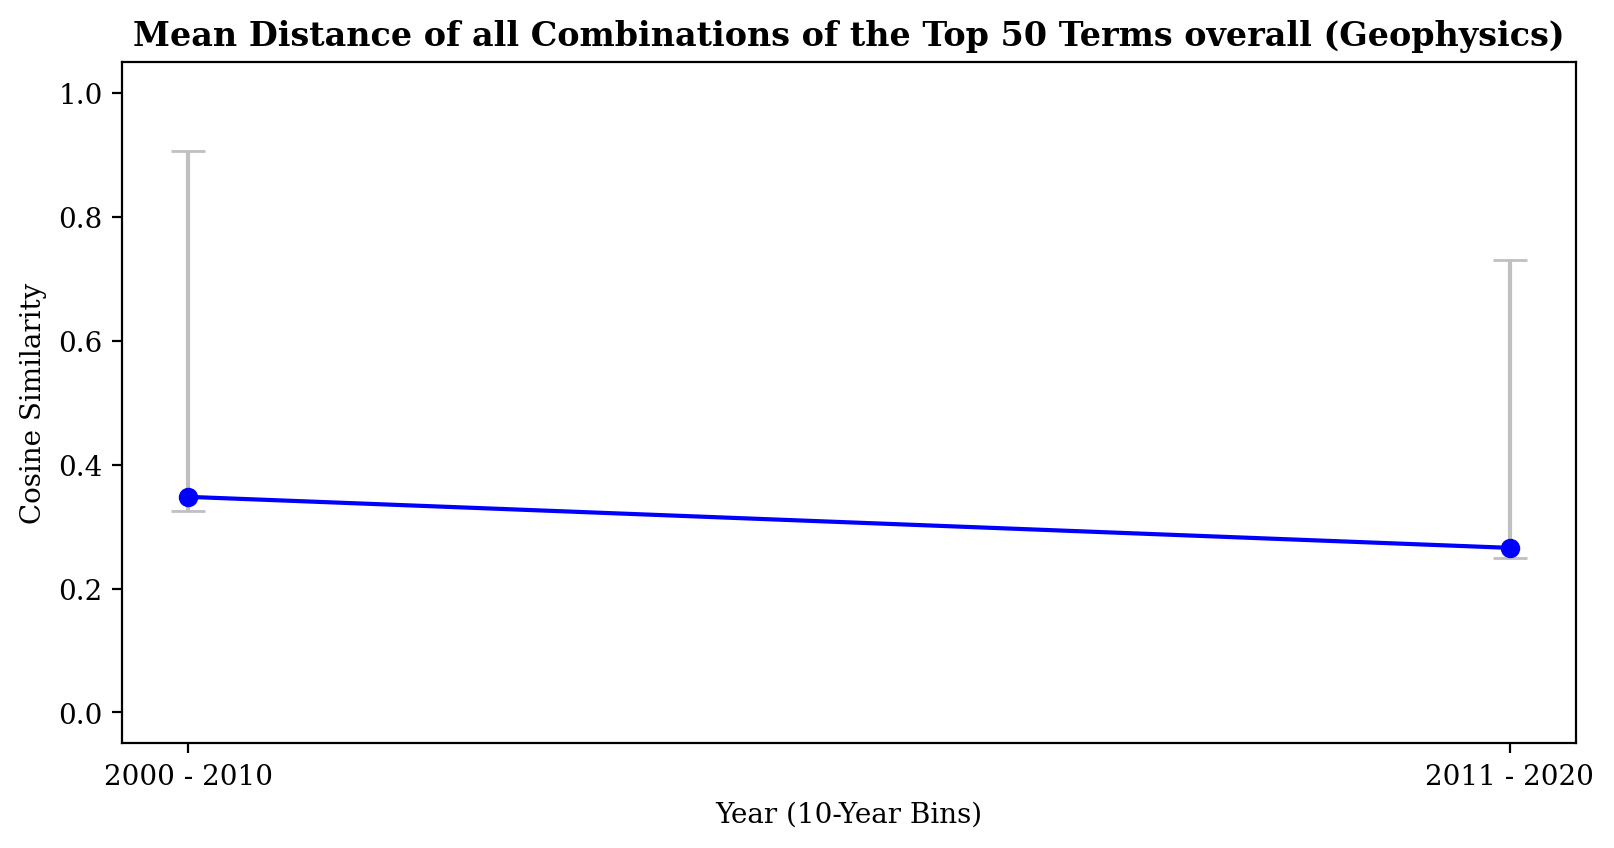

In [104]:
# plot results over time (line graph with error bars)

fig, ax = plt.subplots(figsize = (8, 4), dpi = 200, facecolor = 'white', edgecolor = 'white')
fig.tight_layout()

x = np.arange(0, 2, step=1)

# ftvm for fixed terms, variable model
ftvm_min_array = df.loc['min'][1:].to_numpy()
ftvm_mean_array = df.loc['mean'][1:].to_numpy()
ftvm_max_array = df.loc['max'][1:].to_numpy()

ftvm_y_error = [ftvm_min_array, (ftvm_max_array - ftvm_mean_array)]

plt.xticks(x, ['2000 - 2010', '2011 - 2020'])
ax.set_ylim([-0.05, 1.05])

# change font of ticklabels
for tick in ax.get_xticklabels():
    tick.set_fontname('serif')
for tick in ax.get_yticklabels():
    tick.set_fontname('serif')
        
plt.errorbar(x, ftvm_mean_array, yerr = ftvm_y_error, fmt='o', ecolor = 'silver', capsize=6, color='blue')
plt.plot(x, ftvm_mean_array, color = 'blue')

# plot median
#median_array = df.loc['median'][2:].to_numpy()
#plt.scatter(x, median_array, color = 'black', zorder=1)

plt.title('Mean Distance of all Combinations of the Top 50 Terms overall (Geophysics)', fontweight = 'bold', size = 12,
          **{'fontname':'serif'})
plt.xlabel('Year (10-Year Bins)', size = 10, **{'fontname':'serif'})
plt.ylabel('Cosine Similarity', size = 10, **{'fontname':'serif'})
    
# add legend for black and blue dots
    
plt.show()

 ### CUSTOM W2V MODEL (VARIABLE TERMS, VARIABLE MODEL)

In [105]:
n = 50

# collapse dataset with general indexing
dummy_words = [('w' + str(i)) for i in range(0,n)]
dummy_combinations = list(itertools.combinations(dummy_words, 2))

In [157]:
# for each of the five 10-Year bins, flatten list of lists

# break stemmed_tokens into five 10-Year bins, subset terms according to time period
flat_2000_2010 = list(itertools.chain(*aggregated_2000_2010))
flat_2011_2020 = list(itertools.chain(*aggregated_2011_2020))

# top 10 and 25% of thresholds instead ofr absolute count of words
#n1 = round(len(flat_2000_2010) * 0.25)
#n2 = round(len(flat_2011_2020) * 0.25)

n1, n2 = n, n

# count the top n terms per bucket
top_terms_2000_2010 = wordcounter(flat_2000_2010, n1)['word'].tolist()
top_terms_2011_2020 = wordcounter(flat_2011_2020, n2)['word'].tolist()

# get all possible word tuples
tuples_2000_2010 = list(itertools.combinations(top_terms_2000_2010, 2))
tuples_2011_2020 = list(itertools.combinations(top_terms_2011_2020, 2))

In [158]:
# define list of models and list of model names (for columns in dataframe)
models = [fieldW2V_2000_2010, fieldW2V_2011_2020]

columns = ['fieldW2V_2000_2010', 'fieldW2V_2011_2020']

binned_tuples = [tuples_2000_2010, tuples_2011_2020]

#base_df = pd.DataFrame({'word pair': dummy_combinations})
base_df = pd.DataFrame({'word pair' : []})

# loop through models and get distance of all tuples for each model
for combinations, model, column in zip(binned_tuples, models, columns):
    
    df = pd.DataFrame({'word pair': combinations})
    
    similarity_list = []
    
    for word_pair in combinations:
        similarity = model.wv.similarity(word_pair[0], word_pair[1])
        similarity_list.append(similarity)
        
    df[column] = similarity_list
    
    base_df = base_df.append(df)
    
# calculate min, mean, median, and max for all columns
summary_statistics_2000_2010 =  base_df.agg({'fieldW2V_2000_2010': [min, 'mean', 'median', max]})
summary_statistics_2011_2020 =  base_df.agg({'fieldW2V_2011_2020': [min, 'mean', 'median', max]})

# merge summary statistic dataframes and add merged dataframe back to the main one
summary_statistics = pd.concat([summary_statistics_2000_2010, summary_statistics_2011_2020], axis=1)

base_df = pd.concat([base_df, summary_statistics], axis=0)

#base_df['fieldW2V_2011_2020']['min'] = 0

base_df

,word pair,fieldW2V_2000_2010,fieldW2V_2011_2020
0,"(heat, transfer)",0.758758,NaN
1,"(heat, phase)",0.149237,NaN
2,"(heat, temperatur)",0.374865,NaN
3,"(heat, model)",0.297589,NaN
4,"(heat, energi)",0.283433,NaN
...,...,...,...
1224,"(behavior, chemic)",NaN,0.134777
min,NaN,0.068801,0.050573
mean,NaN,0.354877,0.266653
median,NaN,0.352697,0.263335


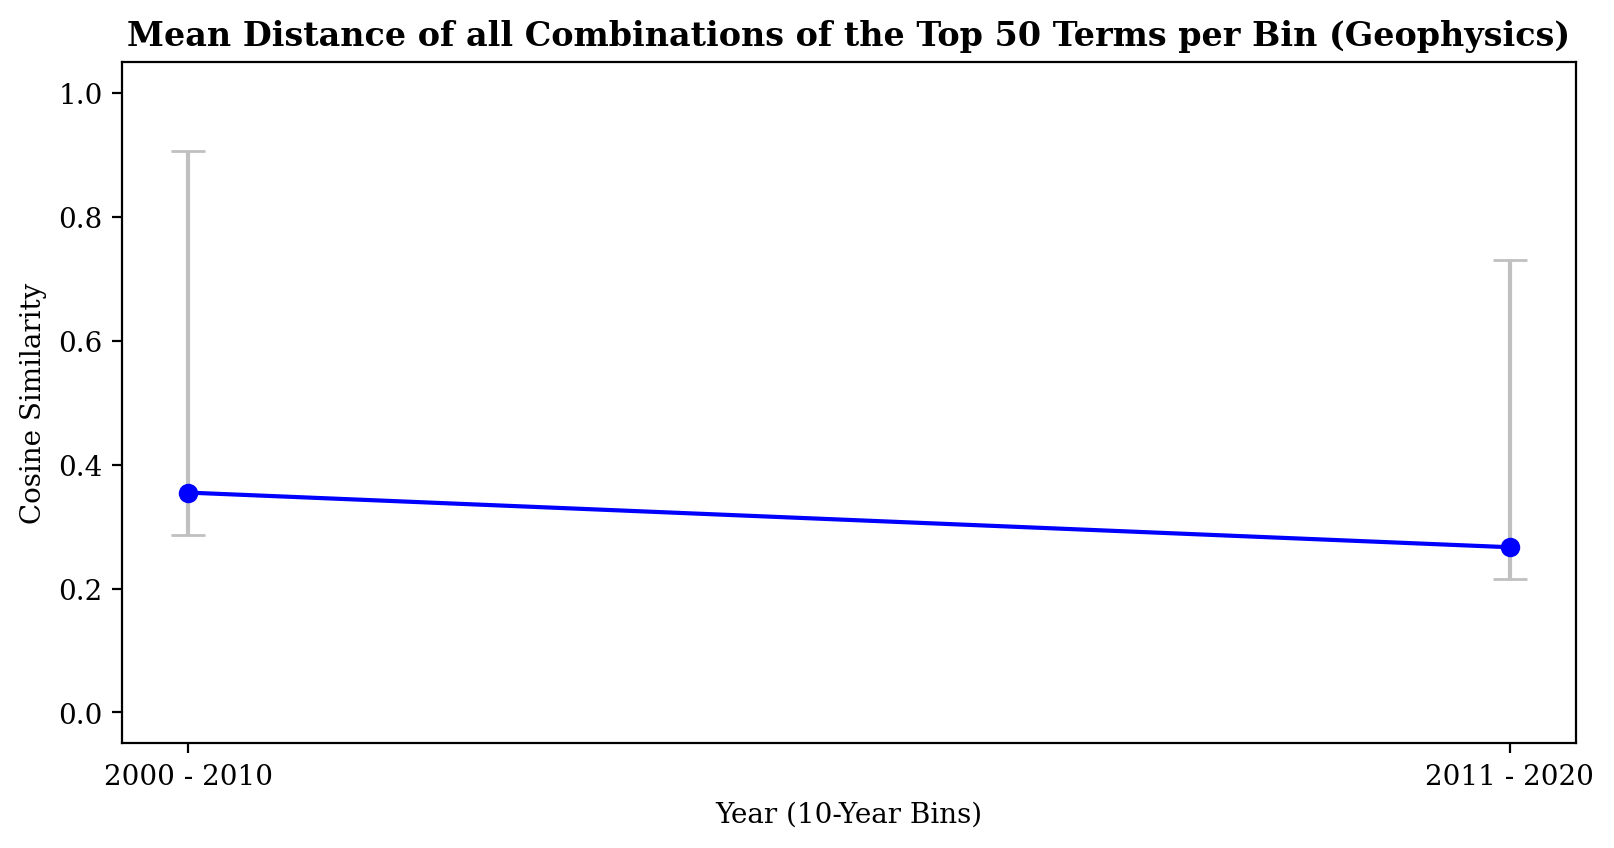

In [108]:
# plot results over time (line graph with error bars)

fig, ax = plt.subplots(figsize = (8, 4), dpi = 200, facecolor = 'white', edgecolor = 'white')
fig.tight_layout()

x = np.arange(0, 2, step=1)

# vtvm for variable terms, variable model
vtvm_min_array = base_df.loc['min'][1:].to_numpy()
vtvm_mean_array = base_df.loc['mean'][1:].to_numpy()
vtvm_max_array = base_df.loc['max'][1:].to_numpy()

vtvm_y_error = [vtvm_min_array, (vtvm_max_array - vtvm_mean_array)]

plt.xticks(x, ['2000 - 2010', '2011 - 2020'])
ax.set_ylim([-0.05, 1.05])

# change font of ticklabels
for tick in ax.get_xticklabels():
    tick.set_fontname('serif')
for tick in ax.get_yticklabels():
    tick.set_fontname('serif')
        
plt.errorbar(x, vtvm_mean_array, yerr = vtvm_y_error, fmt='o', ecolor = 'silver', capsize=6, color='blue')
plt.plot(x, vtvm_mean_array, color = 'blue')

plt.title('Mean Distance of all Combinations of the Top 50 Terms per Bin (Geophysics)', fontweight = 'bold', size = 12,
          **{'fontname':'serif'})
plt.xlabel('Year (10-Year Bins)', size = 10, **{'fontname':'serif'})
plt.ylabel('Cosine Similarity', size = 10, **{'fontname':'serif'})
    
# add legend for black and blue dots
    
plt.show()

 ### COMBINE PLOTS FOR CUSTOM W2V MODELS WITH FIXED TERMS AND  VARIABLE TERMS

In [142]:
thermodynamics_ftvm_mean_array = ftvm_mean_array
thermodynamics_vtvm_mean_array = vtvm_mean_array

print('geophysics', geophysics_ftvm_mean_array, geophysics_vtvm_mean_array)
print('statisticss', statistics_ftvm_mean_array, statistics_vtvm_mean_array)
print('oceanography', oceanography_ftvm_mean_array, oceanography_vtvm_mean_array)
print('biophysics', biophysics_ftvm_mean_array, biophysics_vtvm_mean_array)
print('meteorology', meteorology_ftvm_mean_array, meteorology_vtvm_mean_array)
print('atomic_physics', atomic_physics_ftvm_mean_array, atomic_physics_vtvm_mean_array)
print('thermodynamics', thermodynamics_ftvm_mean_array, thermodynamics_vtvm_mean_array)

geophysics [0.9876435995101929 0.4536314606666565] [0.9871806502342224 0.4518773555755615]
statisticss [0.2922670245170593 0.316986620426178] [0.29363444447517395 0.3153845965862274]
oceanography [0.35887646675109863 0.2784198820590973] [0.3577086627483368 0.27983590960502625]
biophysics [0.27300000190734863 0.31381627917289734] [0.265141099691391 0.31843286752700806]
meteorology [0.8459603190422058 0.3171214163303375] [0.8474429249763489 0.31848183274269104]
atomic_physics [0.3236812949180603 0.25372740626335144] [0.3219977021217346 0.2544030547142029]
thermodynamics [0.3480100929737091 0.2656475007534027] [0.3548774719238281 0.26665252447128296]


In [ ]:
# atomicphysics = black
# biophysics = green
# oceanography = blue
# statistics = purple
# thermodynamics = red
# geophysics = grey
# meteorology = orange

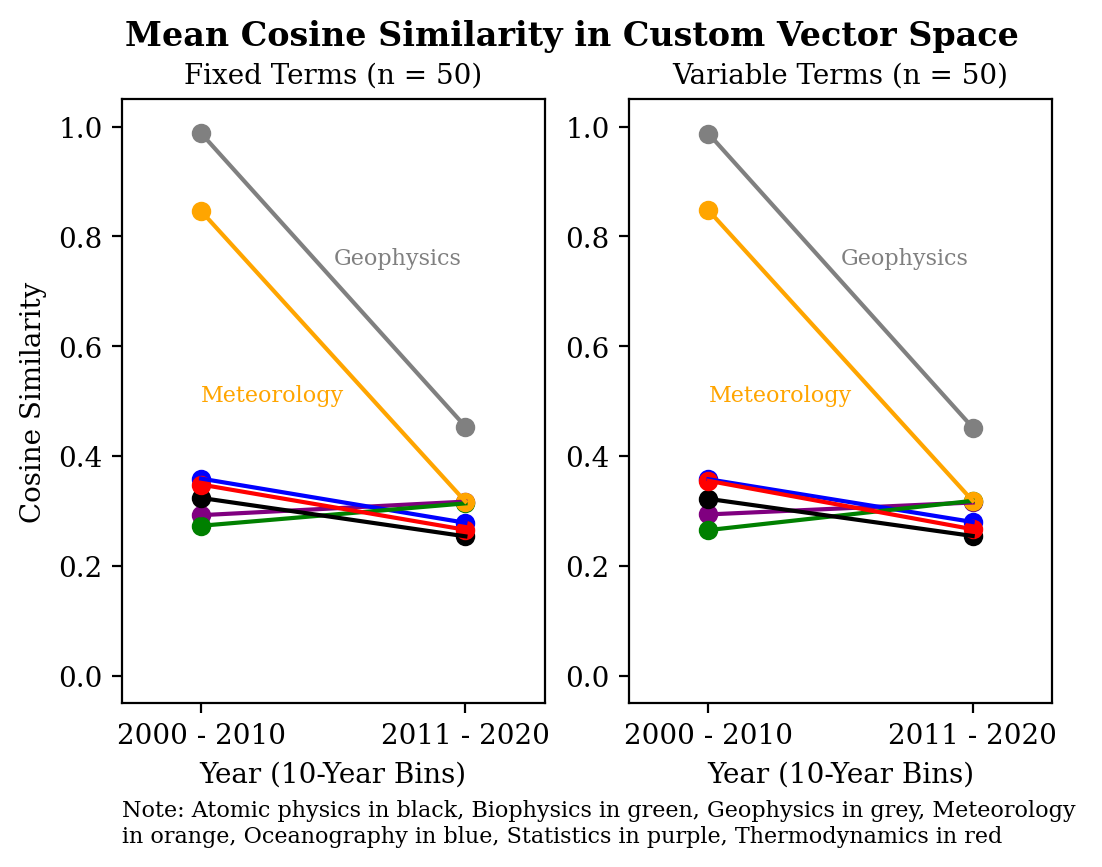

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 4), dpi = 200, facecolor = 'white', edgecolor = 'white')#, sharey=True)

fig.suptitle('Mean Cosine Similarity in Custom Vector Space', fontweight = 'bold', size = 12,
             **{'fontname':'serif'})

plt.setp([ax1, ax2], xticks=np.arange(0, 2, step=1), xticklabels=['2000 - 2010', '2011 - 2020'])

ax1.set_xlim([-0.3, 1.3])
ax1.set_ylim([-0.05, 1.05])

ax1.scatter(x, geophysics_ftvm_mean_array, color = 'grey')
ax1.plot(x, geophysics_ftvm_mean_array, color = 'grey')

ax1.scatter(x, statistics_ftvm_mean_array, color = 'purple')
ax1.plot(x, statistics_ftvm_mean_array, color = 'purple')

ax1.scatter(x, oceanography_ftvm_mean_array, color = 'blue')
ax1.plot(x, oceanography_ftvm_mean_array, color = 'blue')

ax1.scatter(x, biophysics_ftvm_mean_array, color = 'green')
ax1.plot(x, biophysics_ftvm_mean_array, color = 'green')

ax1.scatter(x, meteorology_ftvm_mean_array, color = 'orange')
ax1.plot(x, meteorology_ftvm_mean_array, color = 'orange')

ax1.scatter(x, atomic_physics_ftvm_mean_array, color = 'black')
ax1.plot(x, atomic_physics_ftvm_mean_array, color = 'black')

ax1.scatter(x, thermodynamics_ftvm_mean_array, color = 'red')
ax1.plot(x, thermodynamics_ftvm_mean_array, color = 'red')

ax2.set_xlim([-0.3, 1.3])
ax2.set_ylim([-0.05, 1.05])

ax2.scatter(x, geophysics_vtvm_mean_array, color = 'grey')
ax2.plot(x, geophysics_vtvm_mean_array, color = 'grey')

ax2.scatter(x, statistics_vtvm_mean_array, color = 'purple')
ax2.plot(x, statistics_vtvm_mean_array, color = 'purple')

ax2.scatter(x, oceanography_vtvm_mean_array, color = 'blue')
ax2.plot(x, oceanography_vtvm_mean_array, color = 'blue')

ax2.scatter(x, biophysics_vtvm_mean_array, color = 'green')
ax2.plot(x, biophysics_vtvm_mean_array, color = 'green')

ax2.scatter(x, meteorology_vtvm_mean_array, color = 'orange')
ax2.plot(x, meteorology_vtvm_mean_array, color = 'orange')

ax2.scatter(x, atomic_physics_vtvm_mean_array, color = 'black')
ax2.plot(x, atomic_physics_vtvm_mean_array, color = 'black')

ax2.scatter(x, thermodynamics_vtvm_mean_array, color = 'red')
ax2.plot(x, thermodynamics_vtvm_mean_array, color = 'red')

ax1.set_xlabel('Year (10-Year Bins)', size = 10, **{'fontname':'serif'})
ax2.set_xlabel('Year (10-Year Bins)', size = 10, **{'fontname':'serif'})
ax1.set_ylabel('Cosine Similarity', size = 10, **{'fontname':'serif'})

ax1.set_title('Fixed Terms (n = 50)', size = 10, **{'fontname':'serif'})
ax2.set_title('Variable Terms (n = 50)', size = 10, **{'fontname':'serif'})

for tick in ax1.get_xticklabels():
    tick.set_fontname('serif')
for tick in ax1.get_yticklabels():
    tick.set_fontname('serif')
for tick in ax2.get_xticklabels():
    tick.set_fontname('serif')
for tick in ax2.get_yticklabels():
    tick.set_fontname('serif')

ax1.annotate(('Note: Atomic physics in black, Biophysics in green, Geophysics in grey, Meteorology \nin orange, Oceanography in blue, Statistics in purple, Thermodynamics in red'), (0,0), (0, -50), xycoords = 'axes fraction', textcoords = 'offset points', size = 8, **{'fontname':'serif'})

ax1.text(0.5, 0.75, 'Geophysics', fontsize = 8, color= 'grey', bbox = dict(facecolor = 'None', edgecolor= 'None'), **{'fontname':'serif'})
ax1.text(0.0, 0.5, 'Meteorology', fontsize = 8, color= 'orange', bbox = dict(facecolor = 'None', edgecolor= 'None'), **{'fontname':'serif'})

ax2.text(0.5, 0.75, 'Geophysics', fontsize = 8, color= 'grey', bbox = dict(facecolor = 'None', edgecolor= 'None'), **{'fontname':'serif'})
ax2.text(0.0, 0.5, 'Meteorology', fontsize = 8, color= 'orange', bbox = dict(facecolor = 'None', edgecolor= 'None'), **{'fontname':'serif'})

plt.show()

In [143]:
fig.savefig('w2v_totals_50.png', bbox_inches='tight', dpi=800)